In [ ]:
!pip uninstall tensorflow
!pip install tensorflow

In [3]:
import argparse
import csv
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import functools
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import applications
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas
from sklearn import (
    decomposition,
    manifold,
    pipeline,
)



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
! gdown --id 1AqYSHkKGi3lUoxGTpTS3yQ2AVOXoj2i9
import zipfile
local_zip = '/content/gfp.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1AqYSHkKGi3lUoxGTpTS3yQ2AVOXoj2i9
To: /content/gfp.zip
100% 340M/340M [00:02<00:00, 147MB/s]


FEATURE EXTRACTION 

In [6]:
def get_feature(model, metadata):
    print('{}'.format(metadata['id']))
    try:
        img_path = os.path.join('gfp', metadata['gfp'])
        print(img_path)
        if os.path.isfile(img_path):
            #print('is file: {}'.format(img_path))
            try:
                # load image setting the image size to 224 x 224
                img = image.load_img(img_path, target_size=(224, 224))
                # convert image to numpy array
                x = image.img_to_array(img)
                # the image is now in an array of shape (3, 224, 224)
                # but we need to expand it to (1, 2, 224, 224) as Keras is expecting a list of images
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                
                # extract the features
                features = model.predict(x)[0]
                # convert from Numpy to a list of values
                features_arr = np.char.mod('%f', features)

                return {"id": metadata['id'], "features": ','.join(features_arr)}
            except Exception as ex:
                # skip all exceptions for now
                print(ex)
                pass
    except Exception as ex:
        # skip all exceptions for now
        print(ex)
        pass
    return None


In [7]:
def create_features(filename,features):
  with open(filename, 'w') as output:
    w = csv.DictWriter(output, fieldnames=['id', 'features'], delimiter='\t', lineterminator='\n')
    w.writeheader()
    w.writerows(features)


In [ ]:
data = pandas.read_csv("data.csv")
file = "features_"

# VGG-16
model_vgg16 = applications.vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg')
features_vgg16 = map(functools.partial(get_feature,model_vgg16), data.T.to_dict().values())
# remove empty entries
features_vgg16 = filter(None, features_vgg16)
create_features(file+"vgg16.tsv",features_vgg16)





APPLYING TSNE/PCA/PCA-TSNE

In [32]:
def process(data):
    # split the comma delimited string back into a list of values
    transformed = [d.split(',') for d in data['features']]
    # convert image data to float64 matrix. float64 is need for bh_sne
    x_data = np.asarray(transformed).astype('float64')
    x_data = x_data.reshape((x_data.shape[0], -1))
  
    model = decomposition.PCA(n_components=20)

    vis_data = model.fit_transform(x_data)

    # convert the results into a list of dict
    results = []
    for i in range(0, len(data)):
        results.append({
            'id': data['id'][i],
            'x': vis_data[i][0],
            'y': vis_data[i][1]
        })
    return results,model


In [33]:
def write_tsv(results, output_tsv):
    # write to a tab delimited file
    with open(output_tsv, 'w') as output:
        w = csv.DictWriter(
            output, fieldnames=['id', 'x', 'y'], delimiter='\t',
            lineterminator='\n')
        w.writeheader()
        w.writerows(results)


In [35]:
file = "features_"

# VGG-16
data_vgg16 = pandas.read_csv(file+"vgg16.tsv", sep='\t')
results_vgg16,pca_model = process(data_vgg16)
write_tsv(results_vgg16, file+"vgg16_tsne.tsv")


In [36]:
x = []
y = []
# VGG-16
x_vgg16 = []
y_vgg16 = []
for i in results_vgg16:
    x_vgg16.append(i['x'])
    y_vgg16.append(i['y'])
x.append(x_vgg16)
y.append(y_vgg16)
   

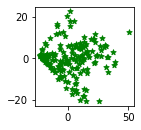

In [37]:
plt.subplot(2,3,1)
plt.scatter(x[0], y[0], label= "stars", color= "green", marker= "*", s=30) 


#plt.scatter(x[2], y[2], label= "stars", color= "green",  
            #marker= "*", s=30) 

In [38]:
from sklearn.cluster import KMeans

def kmean_elbow(df):
  distortions = []
  K = range(1,10)
  for k in K:
      kmeanModel = KMeans(n_clusters=k)
      kmeanModel.fit(df)
      distortions.append(kmeanModel.inertia_)

  plt.figure(figsize=(16,8))
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

APPLYING KMEANS

[[6.4782964359386845, -1.169493099026024], [3.914461597402453, 2.4999332711359132], [7.325839925876417, -4.692371932717999], [12.866930765948107, -5.48008658718011], [6.999054886260547, 6.8701834762251295], [9.424705948508649, 5.2403326952522], [-3.8503434351471157, 3.0065908764949807], [11.89979369479978, 1.6639711245642002], [5.342686536959217, -0.3843359697735219], [9.246842535600265, -2.7278679735594267], [22.51733741060049, 11.668152509681354], [11.36760448778988, -1.4559460323728228], [21.934551189707552, -2.106299430409185], [15.624045385819363, 3.582740684399722], [38.88296909563136, -1.8169036084775976], [15.698427910807762, 3.2742327693619626], [37.972697332377926, -2.9699457453963123], [6.741313400589226, -4.731634173481206], [0.2800895301785061, 5.770100183756453], [4.569766922671036, -8.09023518587153], [15.757399742833984, -6.722209127203153], [16.193612795646846, -5.144814079436666], [-4.328685610945723, -1.223771142674278], [-6.05461219601031, -1.1068445128593107], [21.

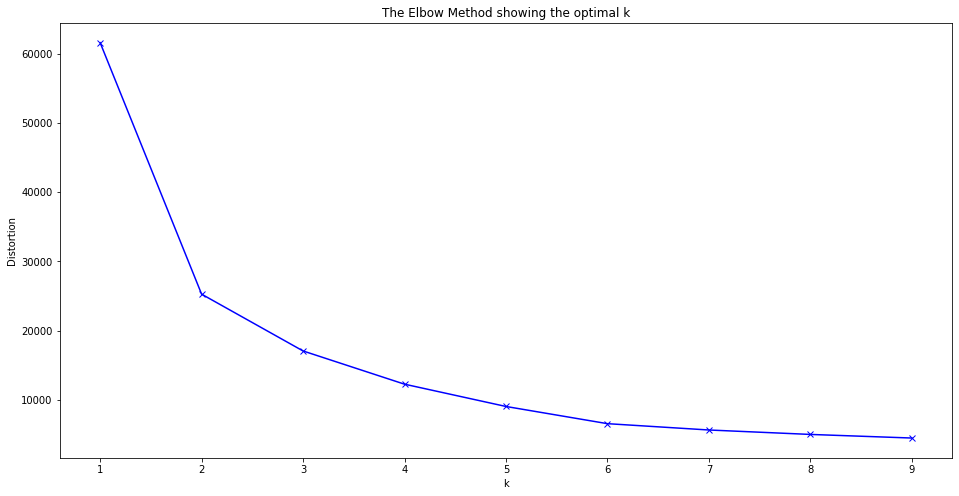

[0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 2 0 0 0 0 0 0 1 2 1 0 1 0 1 0 2 0 1 0 1 2
 1 2 0 0 1 2 0 2 0 2 2 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 0 0 1 1 0 1 0 0 0 2 1 0 2 2 2 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 2 1 1 1 1 1 0 2 1 1 1 1 1 0
 2 1 1 1 0 2 1 0 0 0 1 0 0 0 0 1 1 0 0 0 2 0 1 1 0 1 1 1 1 0 0 2 0 2 0 0 0
 0]


In [39]:
from sklearn.cluster import KMeans

# VGG-16
f_vgg16 = [[d['x'],d['y'] ] for d in results_vgg16]
print(f_vgg16)
kmean_elbow(f_vgg16)
vgg16 = KMeans(n_clusters=3,random_state=0).fit(f_vgg16)
print(vgg16.labels_)

In [40]:
import pickle
pickle.dump(vgg16, open("vgg16.pkl", "wb"))
pickle.dump(pca_model, open("pca.pkl", "wb"))


In [41]:
def process_test_image(img_path):
      try:
            # load image setting the image size to 224 x 224
            img = image.load_img(img_path, target_size=(224, 224))
            # convert image to numpy array
            x = image.img_to_array(img)
           
            # the image is now in an array of shape (3, 224, 224)
            # but we need to expand it to (1, 2, 224, 224) as Keras is expecting a list of images
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            
            model_vgg16 = applications.vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg')
           
            # extract the features
            features = model_vgg16.predict(x)[0]
            # convert from Numpy to a list of values
            features_arr = np.char.mod('%f', features)
            feature_list =  ','.join(features_arr)
            transformed = feature_list.split(',')
         
            # convert image data to float64 matrix. float64 is need for bh_sne
            x_data = np.asarray(transformed).astype('float64')
            x_data = x_data.reshape((1,-1))
            # perform t-SNE
           
            vis_data = pca_model.transform(x_data)


            # convert the results into a list of dict
            results = []
            return vis_data[0][0], vis_data[0][1]
      except Exception as ex:
            # skip all exceptions for now
            print(ex)
            pass


In [42]:
# load the model
model_vgg16 = pickle.load(open("vgg16.pkl", "rb"))
pca_model = pickle.load(open("pca.pkl", "rb"))

In [62]:
x1,y1 = process_test_image('test.png')
print([x1,y1])

print(model_vgg16.predict([[x1,y1]]))

1/1 [==============================] - 1s 688ms/step
[0.7961546410465479, -2.5606376374294455]
[0]
